In [1]:
from src.util import DataLoader, AortaNormalizer
from src.visualiazation import plot_pca, plot_random_predictions, plot_relative_error_aorta
import matplotlib.pyplot as plt
import numpy as np
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

**Load Data**

In [2]:
data_path = "/data/PulHypStudie_Check_npz_v2/"

In [3]:
data_list = [i for i in range(1, 10)]
data_list # pig 10 -> test pig

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [4]:
data_loader = DataLoader(data_path)

X, Y, Pig = data_loader.load_data(data_list,)

Data path: /data/PulHypStudie_Check_npz_v2/ contains 10 pigs:
⋅ P_01_PulHyp
⋅ P_02_PulHyp
⋅ P_03_PulHyp
⋅ P_04_PulHyp
⋅ P_05_PulHyp
⋅ P_06_PulHyp
⋅ P_07_PulHyp
⋅ P_08_PulHyp
⋅ P_09_PulHyp
⋅ P_10_PulHyp
Got a list of 9 pigs to load.
To load ['P_01_PulHyp' 'P_02_PulHyp' 'P_03_PulHyp' 'P_04_PulHyp' 'P_05_PulHyp'
 'P_06_PulHyp' 'P_07_PulHyp' 'P_08_PulHyp' 'P_09_PulHyp']
Loading data from /data/PulHypStudie_Check_npz_v2/P_01_PulHyp
Loading data from /data/PulHypStudie_Check_npz_v2/P_02_PulHyp
Loading data from /data/PulHypStudie_Check_npz_v2/P_03_PulHyp
Loading data from /data/PulHypStudie_Check_npz_v2/P_04_PulHyp
Loading data from /data/PulHypStudie_Check_npz_v2/P_05_PulHyp
Loading data from /data/PulHypStudie_Check_npz_v2/P_06_PulHyp
Loading data from /data/PulHypStudie_Check_npz_v2/P_07_PulHyp
Loading data from /data/PulHypStudie_Check_npz_v2/P_08_PulHyp
Loading data from /data/PulHypStudie_Check_npz_v2/P_09_PulHyp

Aorta curve min=5.65, max=179.42
Eit.shape=(73536, 64, 1024, 1), Y.shape

In [5]:
aorta_normalizer = AortaNormalizer()
Y_norm = aorta_normalizer.normalize_forward(Y)
Y_true = Y[:,:,0]

assert np.allclose(Y_true,aorta_normalizer.normalize_inverse(Y_norm)[:,:,0])

**Load VAE**

In [6]:
import keras_tuner as kt

import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import (
    Dense,
    Flatten,
    BatchNormalization,
    Activation,
    Conv1D,
    ZeroPadding1D,
    Reshape,
    Cropping1D,
)
from tensorflow.keras.layers import Conv1DTranspose
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import Mean

class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, beta, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.total_loss_tracker = Mean(name="total_loss")
        self.reconstruction_loss_tracker = Mean(name="reconstruction_loss")
        self.kl_loss_tracker = Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            loss, reconstruction_loss, kl_loss = self.vae_loss(
                data, reconstruction, z_mean, z_log_var
            )

        gradients = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))

        self.total_loss_tracker.update_state(loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        loss, reconstruction_loss, kl_loss = self.vae_loss(
            data, reconstruction, z_mean, z_log_var
        )

        self.total_loss_tracker.update_state(loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)

    def vae_loss(self, inputs, outputs, z_mean, z_log_var):
        mse_loss_fn = MeanSquaredError()
        input_dim = 1024
        reconstruction_loss = mse_loss_fn(inputs, outputs) * input_dim
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        total_loss = reconstruction_loss + self.beta * kl_loss
        return total_loss, reconstruction_loss, kl_loss


# The encoder model
def encoder_model(
    input_shape=(1024, 1),
    channels=(5, 10, 20, 30),
    strides=(4, 4, 4, 4),
    kernel_size=(5, 5, 5, 5),
    latent_dim=8,
):
    encoder_inputs = Input(shape=input_shape)
    x = encoder_inputs

    for ch_n, str_n, kernel_s in zip(channels, strides, kernel_size):
        x = Conv1D(ch_n, kernel_s, padding="same", strides=1)(x)
        x = BatchNormalization()(x)
        x = Activation("elu")(x)

        x = Conv1D(ch_n, kernel_s, padding="same", strides=str_n)(x)
        x = BatchNormalization()(x)
        x = Activation("elu")(x)

    x = Flatten()(x)

    z_mean = Dense(latent_dim, name="z_mean")(x)
    z_log_var = Dense(latent_dim, name="z_log_var")(x)

    z = Sampling()((z_mean, z_log_var))

    return encoder_inputs, z_mean, z_log_var, z


# The decoder model
def decoder_model(
    latent_dim=8,
    channels=(30, 20, 10, 5),
    strides=(4, 4, 4, 4),
    kernel_size=(5, 5, 5, 5),
):
    latent_inputs = Input(shape=(latent_dim,))
    L = (1024 // np.prod(strides)) * channels[0]
    x = Dense(L, activation="elu")(latent_inputs)
    x = Reshape((1024 // np.prod(strides), channels[0]))(x)

    for ch_n, str_n, kernel_s in zip(channels, strides, kernel_size):
        x = Conv1DTranspose(ch_n, kernel_s, padding="same", strides=str_n)(x)
        x = BatchNormalization()(x)
        x = Activation("elu")(x)

        x = Conv1D(ch_n, kernel_s, padding="same", strides=1)(x)
        x = BatchNormalization()(x)
        x = Activation("elu")(x)

    x = Conv1DTranspose(1, 1, activation="elu", padding="same")(x)
    decoded = x

    return latent_inputs, decoded
    
def build_vae_model(hp):
    latent_dim = hp.Int("latent_dim", min_value=4, max_value=16, step=4)
    beta = hp.Float("beta", min_value=0.1, max_value=2.0, step=0.1)
    #num_channels_choice = hp.Choice("num_channels", values=[5, 10, 20, 30])
    kernel_size = hp.Int("kernel_size", min_value=3, max_value=9, step=1)  
    strides = hp.Int("strides", min_value=2, max_value=4, step=1)
        
    channels=(5, 10, 20, 30)
    # kernel_sizes=(5, 5, 5, 5)
    kernel_sizes = [kernel_size] * 4
    # strides=(4, 4, 4, 4)
    stride_sizes = [strides] * 4

    # Build encoder and decoder
    encoder_inputs, z_mean, z_log_var, z = encoder_model(
        channels=channels,
        kernel_size=kernel_sizes,
        strides=stride_sizes,
        latent_dim=latent_dim,
    )
    encoder = Model(encoder_inputs, (z_mean, z_log_var, z), name="Encoder")
    
    decoder_inputs, decoder_outputs = decoder_model(
        channels=channels[::-1],
        kernel_size=kernel_sizes[::-1],
        strides=stride_sizes[::-1],
        latent_dim=latent_dim,
    )
    decoder = Model(decoder_inputs, decoder_outputs, name="Decoder")

    encoder.summary()
    decoder.summary()
    vae = VAE(encoder, decoder, beta=beta)

    vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice("lr", [1e-3, 1e-4, 1e-5])))
    return vae

# Instantiate the tuner
tuner = kt.Hyperband(
    build_vae_model,
    objective="loss",
    max_epochs=20,
    factor=2,
    directory="vae_hpt",
    project_name="vae_tuning_1",
)

2024-12-19 16:32:43.698466: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-19 16:32:44.351352: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Reloading Tuner from vae_hpt/vae_tuning_1/tuner0.json


In [7]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [8]:
vae = tuner.hypermodel.build(best_hps)

2024-12-19 16:32:45.633108: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79087 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:4c:00.0, compute capability: 8.0


Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1024, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1024, 5)   │         20 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1024, 5)   │         20 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1024, 5)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 256, 5)    │         80 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 5)    │         20 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 5)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 256, 10)   │        160 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 10)   │         40 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 256, 10)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 64, 10)    │        310 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 10)    │         40 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 10)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 64, 20)    │        620 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 20)    │         80 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 64, 20)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 16, 20)    │      1,220 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 20)    │         80 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 16, 20)    │          0 │ batch_normalizat

 Total params: 9,426 (36.82 KB)

 Trainable params: 9,166 (35.80 KB)

 Non-trainable params: 260 (1.02 KB)

Model: "Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │         1,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 30)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose                │ (None, 16, 30)         │         2,730 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 30)         │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 16, 30)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 16, 30)         │         2,730 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 30)         │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 16, 30)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_1              │ (None, 64, 20)         │         1,820 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64, 20)         │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 64, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 64, 20)         │         1,220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64, 20)         │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 64, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_2              │ (None, 256, 10)        │           610 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 256, 10)        │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 256, 10)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 256, 10)        │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 256, 10)        │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 11,261 (43.99 KB)

 Trainable params: 11,001 (42.97 KB)

 Non-trainable params: 260 (1.02 KB)

In [9]:
# sel_model = "src/weights/vae_model_excl10_0.weights.h5"
# sel_model = "src/weights/vae_model_excl_none_1.weights.h5"
sel_model = "src/weights/vae_model_excl_10_2.weights.h5"

#vae = vae_model()
vae.compile(optimizer=tf.keras.optimizers.Adam())
vae.load_weights(sel_model)
_,_,z = vae.encoder.predict(Y_norm)

/home/jt292/miniconda3/envs/TF/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 146 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
I0000 00:00:1734622367.440046 1365371 service.cc:145] XLA service 0x7fdb54004de0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734622367.440135 1365371 service.cc:153]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2024-12-19 16:32:47.467457: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-19 16:32:47.540487: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


  78/2298 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step

I0000 00:00:1734622368.442180 1365371 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2298/2298 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


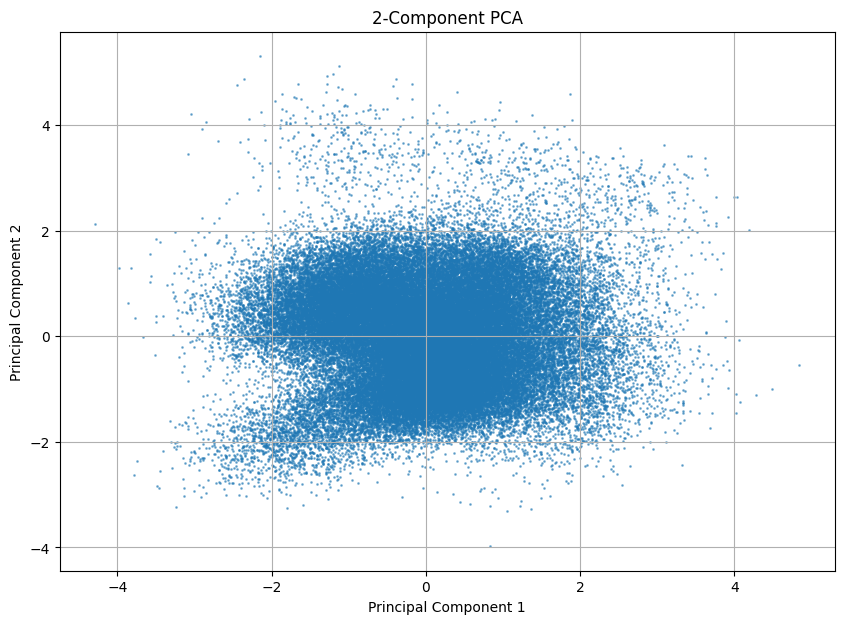

In [10]:
plot_pca(z)

**Train Mapper**

- [KerasTuner](https://www.tensorflow.org/tutorials/keras/keras_tuner)

In [14]:
import keras_tuner as kt
from tensorflow import keras

In [15]:
def build_model(hp):
    latent_dim = 8
    # initialize the sequential model.
    model = keras.Sequential()
    # input layer
    model.add(keras.layers.Input(shape=(64, 1024, 1)))
    
    # tune the number of hidden layers and units in each.
    for i in range(1, hp.Int("num_layers", 4, 7)):
        print(f"Init layer {i=}")
        hp_units = hp.Int("units_" + str(i), min_value=2, max_value=16, step=4)
        hp_kernel = hp.Int("kernel_" + str(i), min_value=2, max_value=9, step=1)
        # stride dim (0,1)
        hp_strides_0 = hp.Int("units_0_" + str(i), min_value=1, max_value=4, step=1)
        hp_strides_1 = hp.Int("units_1_" + str(i), min_value=2, max_value=4, step=1)
        hp_activation = hp.Choice("activation_" + str(i), values=['relu','elu','tanh'])
        hp_dropout = hp.Float("dropout_" + str(i), 0, 1.0, step=0.1)
        
        # create layer
        model.add(
            keras.layers.Conv2D(hp_units, hp_kernel, strides=(hp_strides_0, hp_strides_1), padding="same")
        )
        model.add(keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation(hp_activation))
        model.add(keras.layers.Dropout(hp_dropout))

    model.add(keras.layers.Flatten())
    # output layer.
    model.add(keras.layers.Dense(latent_dim, activation="linear"))
    
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4,1e-5])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=keras.losses.MeanAbsoluteError(),
                  # loss=keras.losses.MeanSquaredError(),
                  metrics=["accuracy"])
    print(model.summary())

    
    return model

In [16]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=50,
    factor=2,
    directory='hpt_mapper_test10',
    project_name='hpt_mapper_test10'
)


Init layer i=1
Init layer i=2
Init layer i=3


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 64, 512, 2)     │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 64, 512, 2)     │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 64, 512, 2)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64, 512, 2)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 256, 2)     │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 64, 256, 2)     │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 64, 256, 2)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64, 256, 2)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 128, 2)     │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 64, 128, 2)     │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_21 (Activation)      │ (None, 64, 128, 2)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64, 128, 2)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │       131,080 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,150 (512.30 KB)

 Trainable params: 131,138 (512.26 KB)

 Non-trainable params: 12 (48.00 B)

None


In [17]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
tuner.search(X, z, epochs=50,batch_size=20, validation_split=0.2, callbacks=[stop_early])


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
7                 |7                 |num_layers
10                |10                |units_1
9                 |9                 |kernel_1
4                 |4                 |units_0_1
2                 |2                 |units_1_1
elu               |elu               |activation_1
0.4               |0.4               |dropout_1
10                |10                |units_2
7                 |7                 |kernel_2
2                 |2                 |units_0_2
2                 |2                 |units_1_2
elu               |elu               |activation_2
0                 |0                 |dropout_2
10                |10                |units_3
2                 |2                 |kernel_3
1                 |1                 |units_0_3
2                 |2                 |units_1_3
relu              |relu              |activation_3
0.7               |0.7               |dropout_3
0.001  

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 16, 512, 10)    │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 512, 10)    │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 16, 512, 10)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 512, 10)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 256, 10)     │         4,910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 256, 10)     │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 8, 256, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 256, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 128, 10)     │           410 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 128, 10)     │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 8, 128, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 128, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 64, 2)       │            82 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 64, 2)       │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 8, 64, 2)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 64, 2)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 32, 2)       │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 32, 2)       │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 8, 32, 2)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8, 32, 2)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 16, 2)       │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 16, 2)       │             8 │
│ (BatchNormalization)            │                        │             

 Total params: 8,458 (33.04 KB)

 Trainable params: 8,386 (32.76 KB)

 Non-trainable params: 72 (288.00 B)

None
Epoch 1/2
2942/2942 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step - accuracy: 0.1437 - loss: 0.8506 - val_accuracy: 0.2787 - val_loss: 0.7451
Epoch 2/2
 821/2942 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.2660 - loss: 0.7488

In [ ]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
best_hps.values

**Load Best Model**

In [ ]:
model = tuner.hypermodel.build(best_hps)

In [ ]:
# es = EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)
history = model.fit(
    X,
    z,
    epochs=100,
    batch_size=16,
    # callbacks=[es],
    validation_split=0.1,
)

In [ ]:
model.save_weights("src/weights/mapper_model_7.weights.h5")
np.savez("src/weights/mapper_model_7_history.npz", history=history)

**Test model**

In [ ]:
X_test, Y_t, _ = data_loader.load_data(10)

aorta_normalizer = AortaNormalizer()
Y_norm = aorta_normalizer.normalize_forward(Y_t)
Y_true = Y_t[:,:,0]

assert np.allclose(Y_true,aorta_normalizer.normalize_inverse(Y_norm)[:,:,0])

In [ ]:
# predict with trained model
z_pred = model.predict(X_test)
Y_pred = vae.decoder.predict(z_pred)
Y_pred = aorta_normalizer.normalize_inverse(Y_pred)[:,:,0]

In [ ]:
rel_err_config = {
    "std" : True,
    "var" : True,
    "mean" : True,
    "s_name" : "serious_result_1.png",
}

plot_relative_error_aorta(Y_true,Y_pred,**rel_err_config)

In [ ]:
plot_random_predictions(Y_true,Y_pred,n=10)

In [ ]:
from src.LaTeX_export import output_err_for_LaTeX,output_curve_for_LaTeX

In [ ]:
output_err_for_LaTeX(Y_true, Y_pred,f_name = "err_serious_result_1.csv")

In [ ]:
output_curve_for_LaTeX(Y_true, Y_pred,f_name = "curve_serious_result_1.csv")

In [ ]:
Y_true.shape

In [ ]:
DAP = np.min(Y_true,axis=1)-np.min(Y_pred,axis=1)
SAP = np.max(Y_true,axis=1)-np.max(Y_pred,axis=1)
MAP = np.mean(Y_true,axis=1)-np.mean(Y_pred,axis=1)

In [ ]:
import pandas as pd
import seaborn as sns

In [ ]:
dd = {"DAP": DAP, "SAP":SAP, "MAP": MAP}
DF = pd.DataFrame(dd)

In [ ]:
sns.histplot(DF)
plt.savefig("hist_DapSapMap.png")

In [ ]:
sns.boxplot(DF)
plt.grid()
plt.savefig("box_DapSapMap.png")

**Archive**

*Train Mapper*